In [53]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchtext.vocab as vocab
from torchtext.data import get_tokenizer
from torchtext.datasets import SST2
from torch.utils.data import DataLoader
from torchtext.vocab import build_vocab_from_iterator
import OpenAttack as oa
%run models/Linear.ipynb
%run models/RNN.ipynb
%run models/Attention.ipynb

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_iter = SST2(split="train")
val_iter = SST2(split="dev")
# test_iter = SST2(split="test")

tokenizer = get_tokenizer('spacy')

def yield_tokens_adv(data_iter):
    for text, _ in data_iter:
        yield tokenizer(text)

In [4]:
vocabulary = build_vocab_from_iterator(yield_tokens_adv(train_iter), specials=["<unk>"])
vocabulary.set_default_index(vocabulary["<unk>"])
glove_vectors = vocab.GloVe(name='6B', dim=100)
vocabulary.vectors = glove_vectors.get_vecs_by_tokens(vocabulary.get_itos())
BATCH_SIZE = 128
MAX_VOCAB_SIZE = 400000

In [30]:
import datasets


def dataset_mapping(x):
    return {
        "x": x["sentence"],
        "y": 1 if x["label"] > 0.5 else 0,
    }


# configure access interface of the customized victim model by extending OpenAttack.Classifier.
class MyClassifier(oa.Classifier):
    def __init__(self, model, fc=False):
        self.model = model
        self.fc = fc
    def get_pred(self, input_):
        return self.get_prob(input_).argmax(axis=1)

    # access to the classification probability scores with respect input sentences
    def get_prob(self, input_):
        ret = []
        for sent in input_:
            seq = []
            for word in tokenizer(sent):
                seq.append(vocabulary[word])
            v = torch.tensor(seq).view(1, -1)
            v = v.to(device)
            if self.fc:
                res = self.model.forward(v)
            else:
                res, _  = self.model.forward(v)
            res = F.softmax(res)
            res = {"pos": res[0, 0].cpu().detach().numpy(), "neg": res[0, 1].cpu().detach().numpy()}
            # we use 𝑠𝑜𝑐𝑟𝑒_𝑝𝑜𝑠 / (𝑠𝑐𝑜𝑟𝑒_𝑛𝑒𝑔 + 𝑠𝑐𝑜𝑟𝑒_𝑝𝑜𝑠) to represent the probability of positive sentiment
            # Adding 10^−6 is a trick to avoid dividing by zero.
            prob = (res["pos"] + 1e-6) / (res["neg"] + res["pos"] + 2e-6)

            ret.append(np.array([1 - prob, prob]))

        # The get_prob method finally returns a np.ndarray of shape (len(input_), 2). See Classifier for detail.
        return np.array(ret)


dataset = datasets.load_dataset("sst2", split="test[:50]", ).map(function=dataset_mapping)
attacker = oa.attackers.hotflip.HotFlipAttacker()

Found cached dataset sst2 (C:/Users/radug/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5)


Map:   0%|          | 0/50 [00:00<?, ? examples/s]

### Fully Connected Attack

In [38]:
class PerturbationPosition(oa.AttackMetric):
    NAME = "PerturbationPosition"
    def __init__(self):
        self.counts = []
    def after_attack(self, sample, adversarial_sample):
        # print(sample, adversarial_sample)
        if adversarial_sample is None:
            return -1
        sample = tokenizer(sample["sentence"])
        adversarial_sample = tokenizer(adversarial_sample)
        for i, (sentence, sentence_adv) in enumerate(zip(sample, adversarial_sample)):
            for j , (word1, word2) in enumerate(zip(sentence, sentence_adv)):
                if word1 != word2:
                    self.counts.append(j / len(sentence))


net = FC(vocabulary)
net.load_state_dict(torch.load('FC_model.pt'))
net.to(device)
net.eval()
pp = PerturbationPosition()
victim = MyClassifier(net, True)# prepare for attacking
attack_eval = oa.AttackEval(attacker, victim, metrics=[
    pp
])
# launch attacks and print attack results
attack_fc = attack_eval.eval(dataset, visualize=False)
attack_fc

C:\Users\radug\AppData\Local\Temp\ipykernel_12312\3204285435.py:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  res = F.softmax(res)


{'Total Attacked Instances': 50,
 'Successful Instances': 31,
 'Attack Success Rate': 0.62,
 'Avg. Running Time': 0.0022866344451904297,
 'Total Query Exceeded': 0.0,
 'Avg. Victim Model Queries': 47.94,
 'Avg. PerturbationPosition': -1.0}

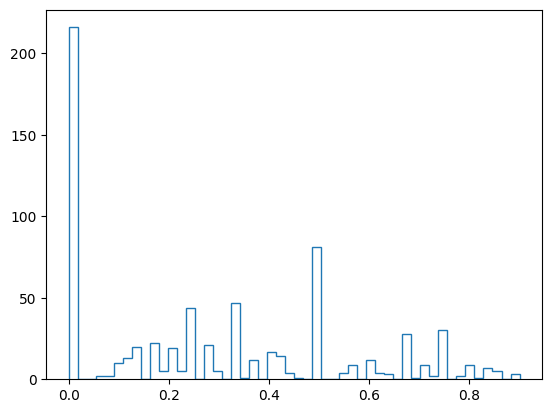

In [39]:
counts = np.array(pp.counts)
counts = counts[counts>=0]
c, b = np.histogram(pp.counts, bins=50)
plt.stairs(c, b)
plt.show()

### RNN Attack

In [48]:
net = RNN(vocabulary)
net.load_state_dict(torch.load('rnn.pt'))
net.to(device)
net.eval()
pp = PerturbationPosition()
victim = MyClassifier(net, False)
# prepare for attacking
attack_eval = oa.AttackEval(attacker, victim, metrics=[
    pp
])
# launch attacks and print attack results
attack_rnn = attack_eval.eval(dataset, visualize=False)
attack_rnn

C:\Users\radug\AppData\Local\Temp\ipykernel_12312\3204285435.py:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  res = F.softmax(res)


{'Total Attacked Instances': 50,
 'Successful Instances': 12,
 'Attack Success Rate': 0.24,
 'Avg. Running Time': 0.003641963005065918,
 'Total Query Exceeded': 0.0,
 'Avg. Victim Model Queries': 70.98,
 'Avg. PerturbationPosition': -1.0}

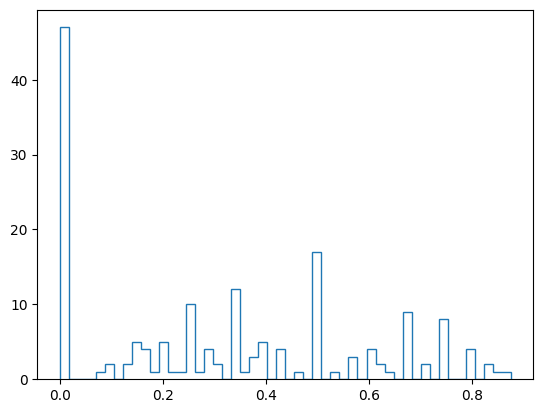

In [49]:
counts = np.array(pp.counts)
counts = counts[counts>=0]
c, b = np.histogram(pp.counts, bins=50)
plt.stairs(c, b)
plt.show()

In [54]:
net = SelfAttention(vocabulary)
net.load_state_dict(torch.load('models/attention.pt'))
net.to(device)
net.eval()
pp = PerturbationPosition()
victim = MyClassifier(net, fc=False)
# prepare for attacking
attack_eval = oa.AttackEval(attacker, victim, metrics=[
    pp
])
# launch attacks and print attack results
attack_att = attack_eval.eval(dataset, visualize=False)
attack_att

C:\Users\radug\AppData\Local\Temp\ipykernel_12312\3204285435.py:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  res = F.softmax(res)


{'Total Attacked Instances': 50,
 'Successful Instances': 36,
 'Attack Success Rate': 0.72,
 'Avg. Running Time': 0.0025842905044555662,
 'Total Query Exceeded': 0.0,
 'Avg. Victim Model Queries': 40.5,
 'Avg. PerturbationPosition': -1.0}

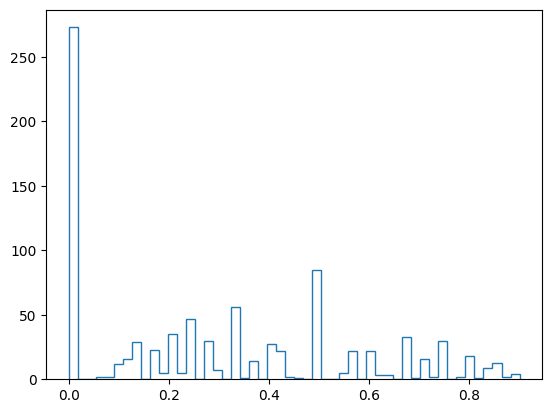

In [55]:
counts = np.array(pp.counts)
counts = counts[counts>=0]
c, b = np.histogram(pp.counts, bins=50)
plt.stairs(c, b)
plt.show()